In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [70]:
# Загружаем основные данные
train_df = pd.read_csv("df_merged_cleaned.csv")

In [71]:
X = train_df.drop(columns=['Цена на арматуру', 'dt'])
y = train_df['Цена на арматуру']

In [72]:
# Разделение на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# Обучение модели
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [74]:
# Прогнозирование
y_pred = model.predict(X_test)

In [75]:
# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
print(f"Средняя абсолютная ошибка: {mae}")


Средняя абсолютная ошибка: 2660.1713735219596


In [76]:
ypred = (model.predict(X_test))

result = pd.DataFrame({'real': y_test, 'pred': ypred})
result['error'] = result['real'] - result['pred']
result = result.sort_index()
result.tail(12)


from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(result['real'], result['pred'])
mse = mean_squared_error(result['real'], result['pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
rmse = mse ** 0.5
print(f"RMSE: {rmse}")

MAE: 2660.1713735219596
MSE: 16685277.693453453
RMSE: 4084.7616446316


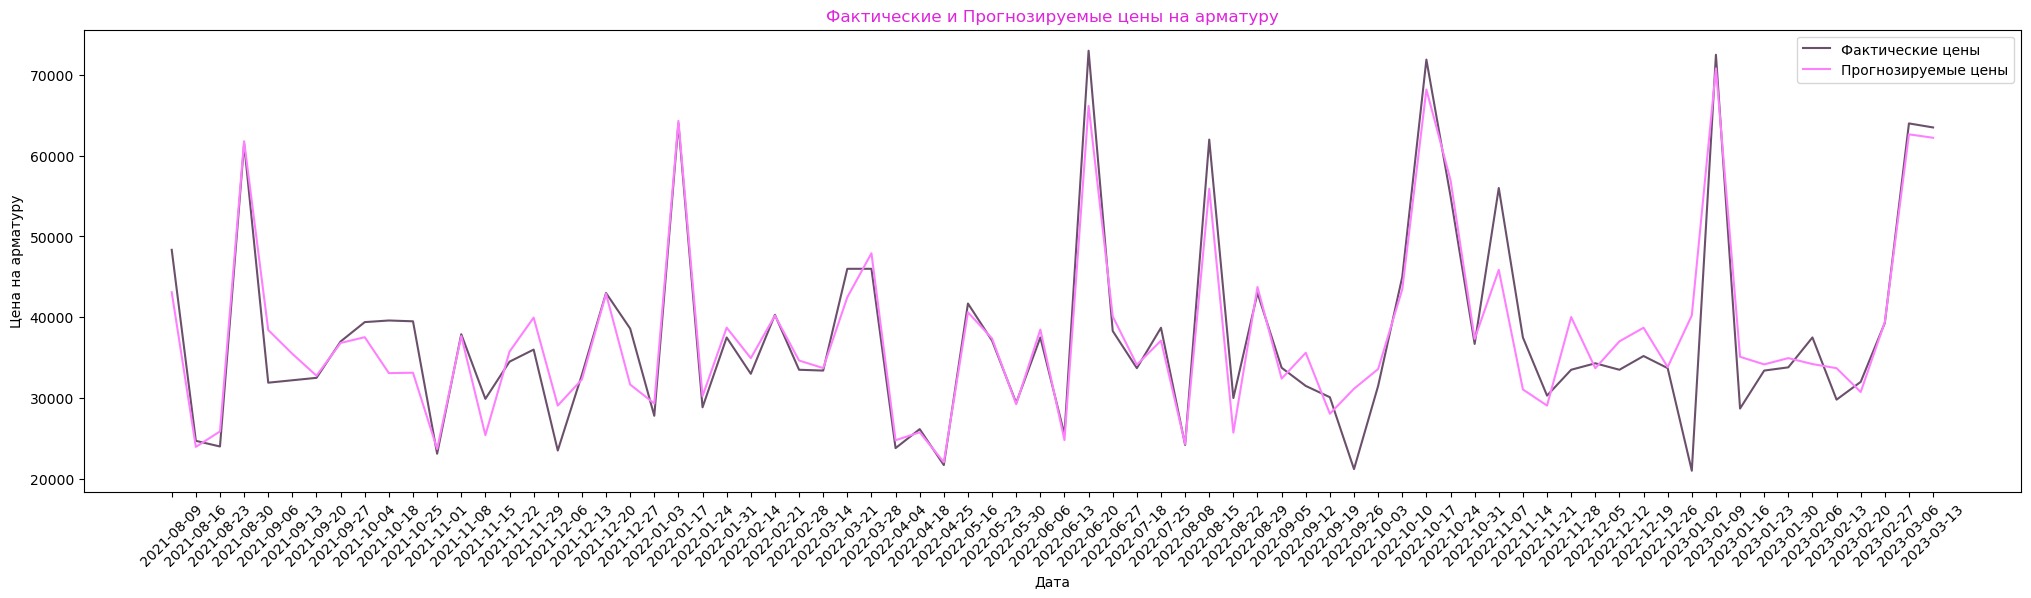

In [87]:
# Визуализация фактических и предсказанных цен
plt.figure(figsize=(25, 6))
plt.plot(train_df["dt"].iloc[-len(y_test):], y_test, label="Фактические цены", color='#6b506b')
plt.plot(train_df["dt"].iloc[-len(y_test):], y_pred, label="Прогнозируемые цены", color='#ff80ff')
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Фактические и Прогнозируемые цены на арматуру",color='#de25da')
plt.xticks(rotation=45)
plt.show()